## Background ##
Immune checkpoint inhibitors (ICIs) have dramatically transformed the clinical care of cancer. For some patients, these drugs extend life and provide durable benefits. However, the majority of patients do not benefit from ICIs; response rates in clinical trials range from 10-50%, and a significant fraction of patients suffer from immune-related adverse events. There is an urgent need for reliable predictors to better select patients for ICI.

In this coding assignment, we will identify patients that will respond well and genes whose mutations may be associated with better or worse outcomes in cancer patients treated with immunotherapy. 

## About the data ## 
0. The data table contains genetic, clinical, and survival information of a cohort of ~1.6K patients treated with ICI. Reference publication where the cleaned dataset is derived from is here: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6365097/
1. Each row is a patient with a unique ID and tumour sequencing barcode, each column is a variable, the data table begins with each sequenced gene where 0 stands for no-mutation and 1 stands for mutation carrier 
2. OS: overall survival (MONTH is the duration of survival, STATUS meaning current state)
3. Stratify the analyses/modelling by CANCER_TYPE 
4. Make sure you correct for/consider the other relevant clinical variables, including TMB_SCORE SEX AGE_GROUP DRUG_TYPE SAMPLE_TYPE

## Key questions for you to answer ##
# Please note some questions may be a bit open-ended and you may run out of time to address them fully. Please feel free to fit solving the assignment into your week, but do not spend over 1.5 working days (or equivalent to 12 hours) on it. # 

#We'd like to access how you think about these problems, break them down into pieces, tackle them with reasonable approaches, and interpret the results, i.e., putting them into biomedical contexts. If you do not have complete answers to all of them it is okay. Feel free to leverage existing tool/algorithms or develop your own as you see suitable. If you find fit, you can choose and attack questions that you are most interested in. #
0. Quick exploratory analyses of data quality. 

1. Which genes' mutation statuses are significantly associated with/predictive of patient survival outcomes? Note: Adverse or beneficial survival outcomes. How do the genes' function possibly relate to immunotherapy response. 

2. Please build a machine learning model that predicts patient survival outcomes based on their relevant clinical variables (TMB_SCORE	SEX	AGE_GROUP	DRUG_TYPE SAMPLE_TYPE) and gene mutation status. Note: Model performance. Feature importance. And how the model predicts outcome. etc. 

3. [Bonus; if you have time] How do the predictors/models compare across cancer types? Are there interactions between the predictors? Anything else you explored? 

4. Technical question: 1) How and why do you choose the specific statistical model or ML algorithm in your analyses? 2) How and why did you define the function or class the way you coded them? 

5. Presentation: imagine you are working on for a conference submission due in two days for a 1-2 page summary of result and figure. Please highlight your key methods and findings in this two-page document, with additional methods and figures in Supplement (if applicable). 



<div style="background-color:lightgrey; padding:10px">

# <font color='red'> Table of Contents </font>
1. [Data Preprocessing](#data-preprocessing)
2. [Logistic Regression](#Logistic-Regression)
3. [Random Forest](#random-forest)
4. [Interaction](#interaction)

</div>



# <font color='blue'> Data Preprocessing and Data Exploration <a name="data-preprocessing"></a></font>

<div style="background-color:lightgrey; padding:10px">
    
The function `preprocess(df)` performs several preprocessing steps on a given dataframe `df`. Here's a breakdown of what each part of the function does:

1. **Outlier Detection and Labeling**: For the columns 'TMB_SCORE' and 'OS_MONTHS', the function calculates the Interquartile Range (IQR) and identifies any values that fall below Q1 - 1.5*IQR or above Q3 + 1.5*IQR as outliers. These outliers are then labeled in new columns 'TMB_SCORE_OUTLIER' and 'OS_MONTHS_OUTLIER' respectively.

2. **Total Mutations Calculation**: The function identifies all gene columns (from 'ABL1' to 'ZRSR2') and calculates the total number of mutations for each row, storing the result in a new column 'TOTAL_MUTATIONS'.

3. **Binary Columns Encoding**: The function uses a LabelEncoder to transform the binary columns ('SEX', 'OS_STATUS', 'SAMPLE_TYPE', 'TMB_SCORE_OUTLIER', 'OS_MONTHS_OUTLIER') into integer format.

4. **Cancer Type Preservation**: The original 'CANCER_TYPE' column is preserved in a new column 'CANCER_TYPE_ORIGINAL'.

5. **One-Hot Encoding**: The function performs one-hot encoding on the multi-categorical columns ('AGE_GROUP', 'DRUG_TYPE', 'CANCER_TYPE').

6. **Normalization**: The numerical columns ('TMB_SCORE', 'OS_MONTHS', 'TOTAL_MUTATIONS') are normalized to a range of 0 to 1.

The function then returns the preprocessed dataframe.
    </div>


In [71]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedShuffleSplit

def preprocess(df):
    for column in ['TMB_SCORE', 'OS_MONTHS']:
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1
        outliers = (df[column] < (Q1 - 1.5 * IQR)) | (df[column] > (Q3 + 1.5 * IQR))
        df[column + '_OUTLIER'] = np.where(outliers, 1, 0)
    gene_columns = df.columns[df.columns.get_loc('ABL1'):df.columns.get_loc('ZRSR2')+1]
    df['TOTAL_MUTATIONS'] = df[gene_columns].sum(axis=1)
    binary_cols = ['SEX', 'OS_STATUS', 'SAMPLE_TYPE', 'TMB_SCORE_OUTLIER', 'OS_MONTHS_OUTLIER']
    le = LabelEncoder()
    for col in binary_cols:
        df[col] = le.fit_transform(df[col]).astype('int32')
    df['CANCER_TYPE_ORIGINAL'] = df['CANCER_TYPE']  
    multi_cols = ['AGE_GROUP', 'DRUG_TYPE', 'CANCER_TYPE']
    df = pd.get_dummies(df, columns=multi_cols)
    num_cols = ['TMB_SCORE', 'OS_MONTHS', 'TOTAL_MUTATIONS']
    for col in num_cols:
        df[col] = (df[col] - df[col].min()) / (df[col].max() - df[col].min())
    return df

## MSKCC Cancer Data Preprocessing

In this notebook, we are working with the MSKCC (Memorial Sloan Kettering Cancer Center) dataset. The dataset is read from a text file 'mskcc.txt' using the `pandas` library. The dataset contains various columns, out of which 'Tumor_Sample_Barcode' and 'ONCOTREE_CODE' are dropped as they are not required for our analysis.

The dataset is indexed by 'PATIENT_ID', making it easier to locate data for specific patients.

## Handling Specific Cancer Type

We identify rows where the 'CANCER_TYPE' is 'Skin Cancer, Non-Melanoma'. These rows are separated and the 'CANCER_TYPE' for these rows is replaced with 'Cancer of Unknown Primary'. This is done to handle this specific cancer type separately.

The main dataframe is then preprocessed using a custom function `preprocess()`. 

## Stratified Split

We perform a stratified shuffle split on the dataframe to create a training set and a test set. The split is stratified based on the 'CANCER_TYPE_ORIGINAL' column. This ensures that the distribution of cancer types is similar in both the training and test sets.

## Creating Test Sets for Each Unique Cancer Type

We create separate test sets for each unique cancer type. This is done to evaluate the performance of our model on each cancer type separately.

The 'CANCER_TYPE_ORIGINAL' column is dropped from the training and test sets as it is not required for training the model. The modified training and test sets are saved as 'train.csv' and 'test.csv' respectively.

Finally, we print the shape of the training dataframe and the separated 'Skin Cancer, Non-Melanoma' dataframe to verify the dimensions of our data.


In [72]:
df = pd.read_csv('mskcc.txt', delimiter='\t')
df = df.drop(['Tumor_Sample_Barcode', 'ONCOTREE_CODE'], axis=1)
df = df.set_index('PATIENT_ID')

# Separate the row with 'Skin Cancer, Non-Melanoma'
index = df[df['CANCER_TYPE'] == 'Skin Cancer, Non-Melanoma'].index
print(index)
df['CANCER_TYPE'] = df['CANCER_TYPE'].replace('Skin Cancer, Non-Melanoma', 'Cancer of Unknown Primary')

# Preprocess the main dataframe
df = preprocess(df)
df.to_csv('df.csv', index=False)

# Preprocess the 'Skin Cancer, Non-Melanoma' row
skin_cancer_row_converted = df.loc[index].copy()
df = df.drop(index)
skin_cancer_row_converted = skin_cancer_row_converted.drop('CANCER_TYPE_ORIGINAL', axis=1)
skin_cancer_row_converted.to_csv('skin.csv', index=False)

# Stratified split
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.35, random_state=42)
for train_index, test_index in sss.split(df, df['CANCER_TYPE_ORIGINAL']):
    train_df = df.iloc[train_index]
    test_df = df.iloc[test_index]

# Create separate test sets for each unique cancer type
Unique_Cancer_Type = df['CANCER_TYPE_ORIGINAL'].unique().tolist()
test_sets = {cancer_type: test_df[test_df['CANCER_TYPE_ORIGINAL'] == cancer_type] for cancer_type in Unique_Cancer_Type}

# Drop the 'CANCER_TYPE_ORIGINAL' column
train_df = train_df.drop('CANCER_TYPE_ORIGINAL', axis=1)
test_df = test_df.drop('CANCER_TYPE_ORIGINAL', axis=1)
for cancer_type in Unique_Cancer_Type:
    test_sets[cancer_type] = test_sets[cancer_type].drop('CANCER_TYPE_ORIGINAL', axis=1)
train_df.to_csv('train.csv', index=False)
#---------
print(train_df.shape)
print(skin_cancer_row_converted.shape)

Index(['P-0024731'], dtype='object', name='PATIENT_ID')
(1045, 500)
(1, 500)


## Handling Missing Values and Verifying DataFrame Structures

In this section of the notebook, we are identifying columns with missing values in our training dataset (`train_df`) and the separated 'Skin Cancer, Non-Melanoma' dataset (`skin_cancer_row_converted`). 

We use the `isnull().any()` function from `pandas` to check for any null values in each column of the dataframes. The columns with missing values are then printed for further inspection.

## Verifying Column Structure

To ensure consistency in our data, we verify if the two dataframes have the same column structure. This is important as inconsistencies in column structure can lead to errors during model training or evaluation.

We use the `equals()` function from `pandas` to check if the columns in `train_df` are the same as the columns in `skin_cancer_row_converted`. The result of this check is then printed.

This step is crucial in ensuring that our data is ready for the next stages of preprocessing or model training.


In [5]:
train_columns_with_missing_values = train_df.columns[train_df.isnull().any()]
skin_cancer_columns_with_missing_values = skin_cancer_row_converted.columns[skin_cancer_row_converted.isnull().any()]

print("Columns with missing values in train_df:")
print(train_columns_with_missing_values)

print("\nColumns with missing values in skin_cancer_row_converted:")
print(skin_cancer_columns_with_missing_values)

same_structure = train_df.columns.equals(skin_cancer_row_converted.columns)

if same_structure:
    print("The two DataFrames have the same column structure.")
else:
    print("The two DataFrames have different column structures.")

print("Number of rows in training dataset: ", train_df.shape[0])
print("Number of rows in testing dataset: ", test_df.shape[0])

Columns with missing values in train_df:
Index([], dtype='object')

Columns with missing values in skin_cancer_row_converted:
Index([], dtype='object')
The two DataFrames have the same column structure.
Number of rows in training dataset:  1045
Number of rows in testing dataset:  564


## DataFrame Overview and Value Distribution

In this section, we are examining the structure and content of our training DataFrame.

First, we print the shape of the DataFrame to understand its dimensions - the number of rows and columns.

Next, we calculate and print the total number of missing values in the DataFrame. This gives us an idea of the amount of incomplete data we are dealing with.

Finally, we iterate over each column in the DataFrame, printing the distribution of values within each column. This is done using the `value_counts()` function from `pandas`, which returns the count of unique entries in the column. We also print the data type of each column for additional context.

This overview provides valuable insights into the nature of our data, which can guide subsequent data cleaning and preprocessing steps.


In [29]:
print("Shape of the DataFrame:", train_df.shape)
print("Total number of missing values in the DataFrame:", train_df.isnull().sum().sum())

# Value counts
for col in train_df.columns:
    print(f'\n{col} distribution (Data type: {train_df[col].dtype}):')
    print(train_df[col].value_counts())

Shape of the DataFrame: (1045, 500)
Total number of missing values in the DataFrame: 0

ABL1 distribution (Data type: float64):
0.0    1026
1.0      19
Name: ABL1, dtype: int64

ACVR1 distribution (Data type: float64):
0.0    1034
1.0      11
Name: ACVR1, dtype: int64

AGO2 distribution (Data type: float64):
0.0    1038
1.0       7
Name: AGO2, dtype: int64

AKT1 distribution (Data type: float64):
0.0    1028
1.0      17
Name: AKT1, dtype: int64

AKT2 distribution (Data type: float64):
0.0    1035
1.0      10
Name: AKT2, dtype: int64

AKT3 distribution (Data type: float64):
0.0    1036
1.0       9
Name: AKT3, dtype: int64

ALK distribution (Data type: float64):
0.0    980
1.0     65
Name: ALK, dtype: int64

ALOX12B distribution (Data type: float64):
0.0    1033
1.0      12
Name: ALOX12B, dtype: int64

AMER1 distribution (Data type: float64):
0.0    1010
1.0      35
Name: AMER1, dtype: int64

ANKRD11 distribution (Data type: float64):
0.0    1002
1.0      43
Name: ANKRD11, dtype: int64



0.0    1034
1.0      11
Name: RPS6KB2, dtype: int64

RPTOR distribution (Data type: float64):
0.0    1018
1.0      27
Name: RPTOR, dtype: int64

RRAGC distribution (Data type: float64):
0.0    1044
1.0       1
Name: RRAGC, dtype: int64

RRAS distribution (Data type: float64):
0.0    1044
1.0       1
Name: RRAS, dtype: int64

RRAS2 distribution (Data type: float64):
0.0    1044
1.0       1
Name: RRAS2, dtype: int64

RTEL1 distribution (Data type: float64):
0.0    1037
1.0       8
Name: RTEL1, dtype: int64

RUNX1 distribution (Data type: float64):
0.0    1021
1.0      24
Name: RUNX1, dtype: int64

RXRA distribution (Data type: float64):
0.0    1040
1.0       5
Name: RXRA, dtype: int64

RYBP distribution (Data type: float64):
0.0    1041
1.0       4
Name: RYBP, dtype: int64

SDHA distribution (Data type: float64):
0.0    1034
1.0      11
Name: SDHA, dtype: int64

SDHAF2 distribution (Data type: float64):
0.0    1043
1.0       2
Name: SDHAF2, dtype: int64

SDHB distribution (Data type: flo

### Analyzing 'OS_STATUS' Distribution in Test Sets

In this section of the notebook, we are examining the distribution of the 'OS_STATUS' variable in the test sets for each unique cancer type. The 'OS_STATUS' variable indicates the survival status of the patients.

We loop over each unique cancer type and print the value counts of the 'OS_STATUS' variable for the corresponding test set. This gives us an understanding of the number of living and deceased patients in each test set.

This analysis is crucial as it helps us understand the balance of our test sets. Imbalanced test sets might lead to biased performance evaluation of our model.


In [33]:
for cancer_type in Unique_Cancer_Type:
    test_set = test_sets[cancer_type]
    print(f"Distribution of 'OS_STATUS' in {cancer_type} test set:")
    print(test_set['OS_STATUS'].value_counts())


Distribution of 'OS_STATUS' in Breast Cancer test set:
0    12
1     2
Name: OS_STATUS, dtype: int64
Distribution of 'OS_STATUS' in Esophagogastric Cancer test set:
1    21
0    20
Name: OS_STATUS, dtype: int64
Distribution of 'OS_STATUS' in Bladder Cancer test set:
1    44
0    30
Name: OS_STATUS, dtype: int64
Distribution of 'OS_STATUS' in Non-Small Cell Lung Cancer test set:
0    75
1    46
Name: OS_STATUS, dtype: int64
Distribution of 'OS_STATUS' in Glioma test set:
0    26
1    15
Name: OS_STATUS, dtype: int64
Distribution of 'OS_STATUS' in Head and Neck Cancer test set:
1    24
0    21
Name: OS_STATUS, dtype: int64
Distribution of 'OS_STATUS' in Melanoma test set:
1    67
0    43
Name: OS_STATUS, dtype: int64
Distribution of 'OS_STATUS' in Colorectal Cancer test set:
0    20
1    18
Name: OS_STATUS, dtype: int64
Distribution of 'OS_STATUS' in Renal Cell Carcinoma test set:
1    28
0    22
Name: OS_STATUS, dtype: int64
Distribution of 'OS_STATUS' in Cancer of Unknown Primary test 

# <font color='red'> Quick Navigation </font>
1. [Data Preprocessing](#data-preprocessing)
2. [Logistic Regression](#Logistic-Regression)
3. [Random Forest](#random-forest)
4. [Interaction](#interaction)

# <font color='blue'> Logistic Regression Model for Survival Prediction <a name="Logistic-Regression"></a></font>

<div style="background-color:lightgrey; padding:10px">

In this section, we utilize the `LogisticRegression` model from the `sklearn.linear_model` module to predict the survival probabilities of patients based on their gene mutations.

We initialize the logistic regression model with a maximum iteration parameter of 1000 and fit the model with our training data. The 'OS_STATUS' column, which indicates the survival status of the patients, is used as the target variable.

### Calculating Gene Mutation Coefficients

We then calculate the coefficients of the gene mutations for from our ttrainingsets. These coefficients represent the effect of each gene mutation on the survival probability of the patients.

### Predicting Survival Probabilities for Skin Cancer

We also predict the survival probabilities for the separated 'Skin Cancer, Non-Melanoma' row and calculate the coefficients for its gene mutations. These coefficients are also stored in the `gene_effects` dictionary.

### Displaying Top Gene Effects

Finally, we display the top 10 negative and positive effects of gene mutations on the survival probability for the first cancer type in our dictionary. The effects are sorted in ascending order and the top 10 negative and positive effects are printed.

This analysis provides insights into the impact of different gene mutations on the survival probabilities of patients with different types of cancer.
</div>


In [19]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# Initialize the logistic regression model
log_reg = LogisticRegression(max_iter=1000)

# Fit the model with the training data
log_reg.fit(train_df.drop('OS_STATUS', axis=1), train_df['OS_STATUS'])

# Calculate the coefficients for the gene mutations
gene_coefs = log_reg.coef_[0][train_df.columns.get_loc('ABL1'):train_df.columns.get_loc('ZRSR2')+1]

# Initialize a dictionary to store the coefficients for each cancer type
gene_effects = dict(zip(df.columns[df.columns.get_loc('ABL1'):df.columns.get_loc('ZRSR2')+1], gene_coefs))

# Loop over each test set
for cancer_type, test_set in test_sets.items():
    # Predict the probabilities of survival for the test set
    y_pred_proba = log_reg.predict_proba(test_set.drop('OS_STATUS', axis=1))[:, 1]
    
    # Predict the class labels for the test set
    y_pred = log_reg.predict(test_set.drop('OS_STATUS', axis=1))
    
    print(f"Accuracy for {cancer_type}: {accuracy_score(test_set['OS_STATUS'], y_pred)}")

# Predict the probabilities of survival for the skin cancer row
skin_cancer_proba = log_reg.predict_proba(skin_cancer_row_converted.drop('OS_STATUS', axis=1))[:, 1]

# Print the survival probability for the skin cancer row
print(f"Survival probability for 'Skin Cancer, Non-Melanoma': {skin_cancer_proba[0]}")
      
# Assume the true label for the skin cancer row is stored in a variable called true_label
true_label = skin_cancer_row_converted['OS_STATUS']

# Predict the class label for the skin cancer row
skin_cancer_pred = log_reg.predict(skin_cancer_row_converted.drop('OS_STATUS', axis=1))

# Print the gene effects
# Sort the effects in ascending order
sorted_effects = sorted(gene_effects.items(), key=lambda x: x[1])

# Get the top 10 negative effects
print("Top 10 Negative Effects:")
for gene, effect in sorted_effects[:10]:
    print(f"Gene: {gene}, Effect: {effect}")

# Get the top 10 positive effects
print("Top 10 Positive Effects:")
for gene, effect in sorted_effects[-10:]:
    print(f"Gene: {gene}, Effect: {effect}")


Accuracy for Breast Cancer: 0.9285714285714286
Accuracy for Esophagogastric Cancer: 0.5121951219512195
Accuracy for Bladder Cancer: 0.6756756756756757
Accuracy for Non-Small Cell Lung Cancer: 0.7520661157024794
Accuracy for Glioma: 0.6097560975609756
Accuracy for Head and Neck Cancer: 0.5333333333333333
Accuracy for Melanoma: 0.6454545454545455
Accuracy for Colorectal Cancer: 0.631578947368421
Accuracy for Renal Cell Carcinoma: 0.64
Accuracy for Cancer of Unknown Primary: 0.6
Survival probability for 'Skin Cancer, Non-Melanoma': 0.7688493051011894
Top 10 Negative Effects:
Gene: WT1, Effect: -1.6244314580660602
Gene: MYD88, Effect: -1.0487811542809333
Gene: NEGR1, Effect: -1.0371136933409018
Gene: IRS2, Effect: -0.9917947007534361
Gene: KLF4, Effect: -0.9873775202562288
Gene: ASXL2, Effect: -0.9857180464574994
Gene: BLM, Effect: -0.9771531460889902
Gene: BRD4, Effect: -0.9610186854324084
Gene: RAF1, Effect: -0.9589702080918238
Gene: SMAD2, Effect: -0.9556176212081912
Top 10 Positive Eff

## Visualizing Gene Effects

In this section, we are visualizing the top 10 negative and positive effects of gene mutations on the survival probabilities of patients. We use the `matplotlib` library to create a bar plot for this visualization.

We first sort the gene effects in ascending order. Then, we separate the top 10 negative and positive effects. These effects are combined and plotted in a bar plot. The genes with negative effects are colored red, and the genes with positive effects are colored blue.

The resulting plot provides a clear visual representation of the impact of different gene mutations on patient survival probabilities. This can be a valuable tool for understanding the role of different genes in cancer survival.

The plot is saved as a PNG file for future reference.


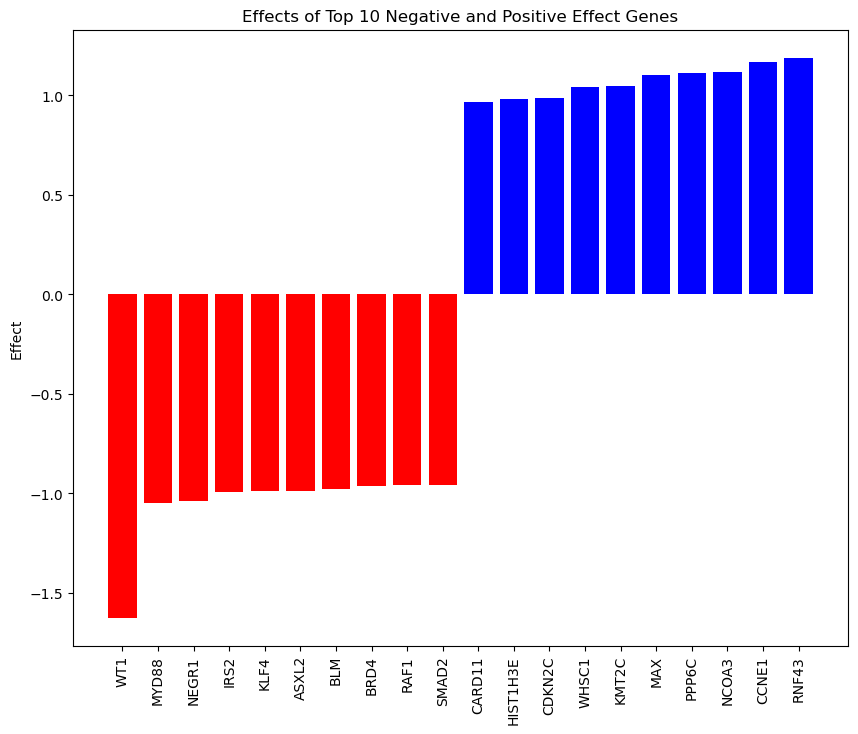

In [21]:
import matplotlib.pyplot as plt

# Sort the effects in ascending order
sorted_effects = sorted(gene_effects.items(), key=lambda x: x[1])

# Get the top 10 negative effects
negative_effects = sorted_effects[:10]

# Get the top 10 positive effects
positive_effects = sorted_effects[-10:]

# Combine the negative and positive effects
combined_effects = negative_effects + positive_effects

# Separate the genes and the effects
genes, effects = zip(*combined_effects)

# Create a color list
colors = ['red' if effect < 0 else 'blue' for effect in effects]

# Create the bar plot
plt.figure(figsize=(10, 8))
plt.bar(genes, effects, color=colors)
plt.xticks(rotation=90)
plt.ylabel('Effect')
plt.title('Effects of Top 10 Negative and Positive Effect Genes')

# Save the plot as a PNG file
plt.savefig('Effects of Top 10 Negative and Positive Effect Genes_LogisticRegression.png', bbox_inches='tight')

plt.show()


# Linear Regression Model and Residual Analysis

In this section, we are implementing a Linear Regression model using the `sklearn` library. The target variable is 'OS_STATUS' from our training dataset. 

The steps involved are:

1. **Model Fitting:** We fit the Linear Regression model on our training data. The independent variables (X) are all columns except 'OS_STATUS', and the dependent variable (y) is 'OS_STATUS'.

2. **Residual Calculation:** After fitting the model, we calculate the residuals. Residuals are the difference between the actual values (y) and the predicted values from our model.

3. **Residual Plotting:** We then plot the residuals against the predicted values. This plot helps us understand the variance of our model's errors. If the points in the residual plot are randomly dispersed around the horizontal axis, it suggests that the regression model is appropriate for the data; otherwise, a non-linear model may be more suitable.

4. **Saving the Plot:** Finally, we save the plot as a PNG file for future reference.

The code block below executes these steps.


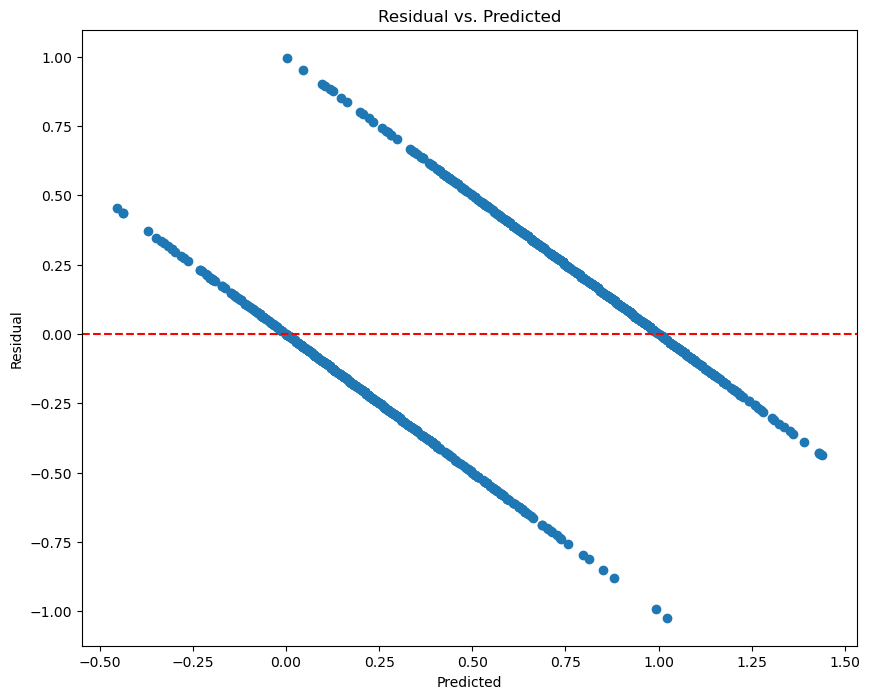

In [34]:
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

# Fit a linear model
lr = LinearRegression()
X = train_df.drop('OS_STATUS', axis=1)
y = train_df['OS_STATUS']
lr.fit(X, y)

# Calculate the residuals
residuals = y - lr.predict(X)

# Plot the residuals
plt.figure(figsize=(10, 8))
plt.scatter(lr.predict(X), residuals)
plt.xlabel('Predicted')
plt.ylabel('Residual')
plt.axhline(y=0, color='red', linestyle='--')
plt.title('Residual vs. Predicted')


# Save the plot as a PNG file
plt.savefig('Residual vs Predicted_LogisticRegression.png', bbox_inches='tight')

plt.show()


# <font color='red'> Quick Navigation </font>
1. [Data Preprocessing](#data-preprocessing)
2. [Logistic Regression](#Logistic-Regression)
3. [Random Forest](#random-forest)
4. [Interaction](#interaction)

# <font color='blue'> Training and Evaluating RandomForest Classifier <a name="random-forest"></a></font>

<div style="background-color:lightgrey; padding:10px">

In this part of the notebook, we are using a Random Forest Classifier to classify different types of cancer based on a given dataset. The model is trained once and then used to predict and evaluate the performance for each unique cancer type.

The steps followed in this notebook are:

1. **Initialize the Random Forest model**: We use the `RandomForestClassifier` from sklearn and set the `random_state` to 42 for reproducibility.

2. **Prepare the training data**: We separate the features (`X_train`) and the label (`y_train`) from the `train_df` dataframe and train the model.

3. **Evaluate the model**: We define a function `evaluate` that takes the trained model, a test dataframe, and a cancer type as inputs. It separates the features and the label from the test dataframe, makes predictions using the trained model, and evaluates the performance by calculating the accuracy and generating a classification report and a confusion matrix.

4. **Calculate feature importances**: Inside the `evaluate` function, we also calculate the feature importances using the `feature_importances_` attribute of the model.

5. **Loop over all cancer types**: We call the `evaluate` function for each unique cancer type in our data, storing the feature importances and performance metrics for each cancer type.

6. **Print feature importances**: We print the top 20 gene mutations, the importances of some specific features, and the top 3 age groups.

7. **Plot feature importances**: We create a bar plot of the feature importances, highlighting the top genes, other features, and top age groups.

This analysis helps us understand which features are most important when classifying different types of cancer, which can be useful for further research and development of cancer treatments.

</div>


In [73]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from operator import itemgetter
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

Model Performance for Breast Cancer:
Accuracy: 0.9285714285714286
              precision    recall  f1-score   support

           0       0.92      1.00      0.96        12
           1       1.00      0.50      0.67         2

    accuracy                           0.93        14
   macro avg       0.96      0.75      0.81        14
weighted avg       0.93      0.93      0.92        14

[[12  0]
 [ 1  1]]
Model Performance for Esophagogastric Cancer:
Accuracy: 0.5365853658536586
              precision    recall  f1-score   support

           0       0.52      0.70      0.60        20
           1       0.57      0.38      0.46        21

    accuracy                           0.54        41
   macro avg       0.54      0.54      0.53        41
weighted avg       0.55      0.54      0.52        41

[[14  6]
 [13  8]]
Model Performance for Bladder Cancer:
Accuracy: 0.6486486486486487
              precision    recall  f1-score   support

           0       0.57      0.57      0.57  

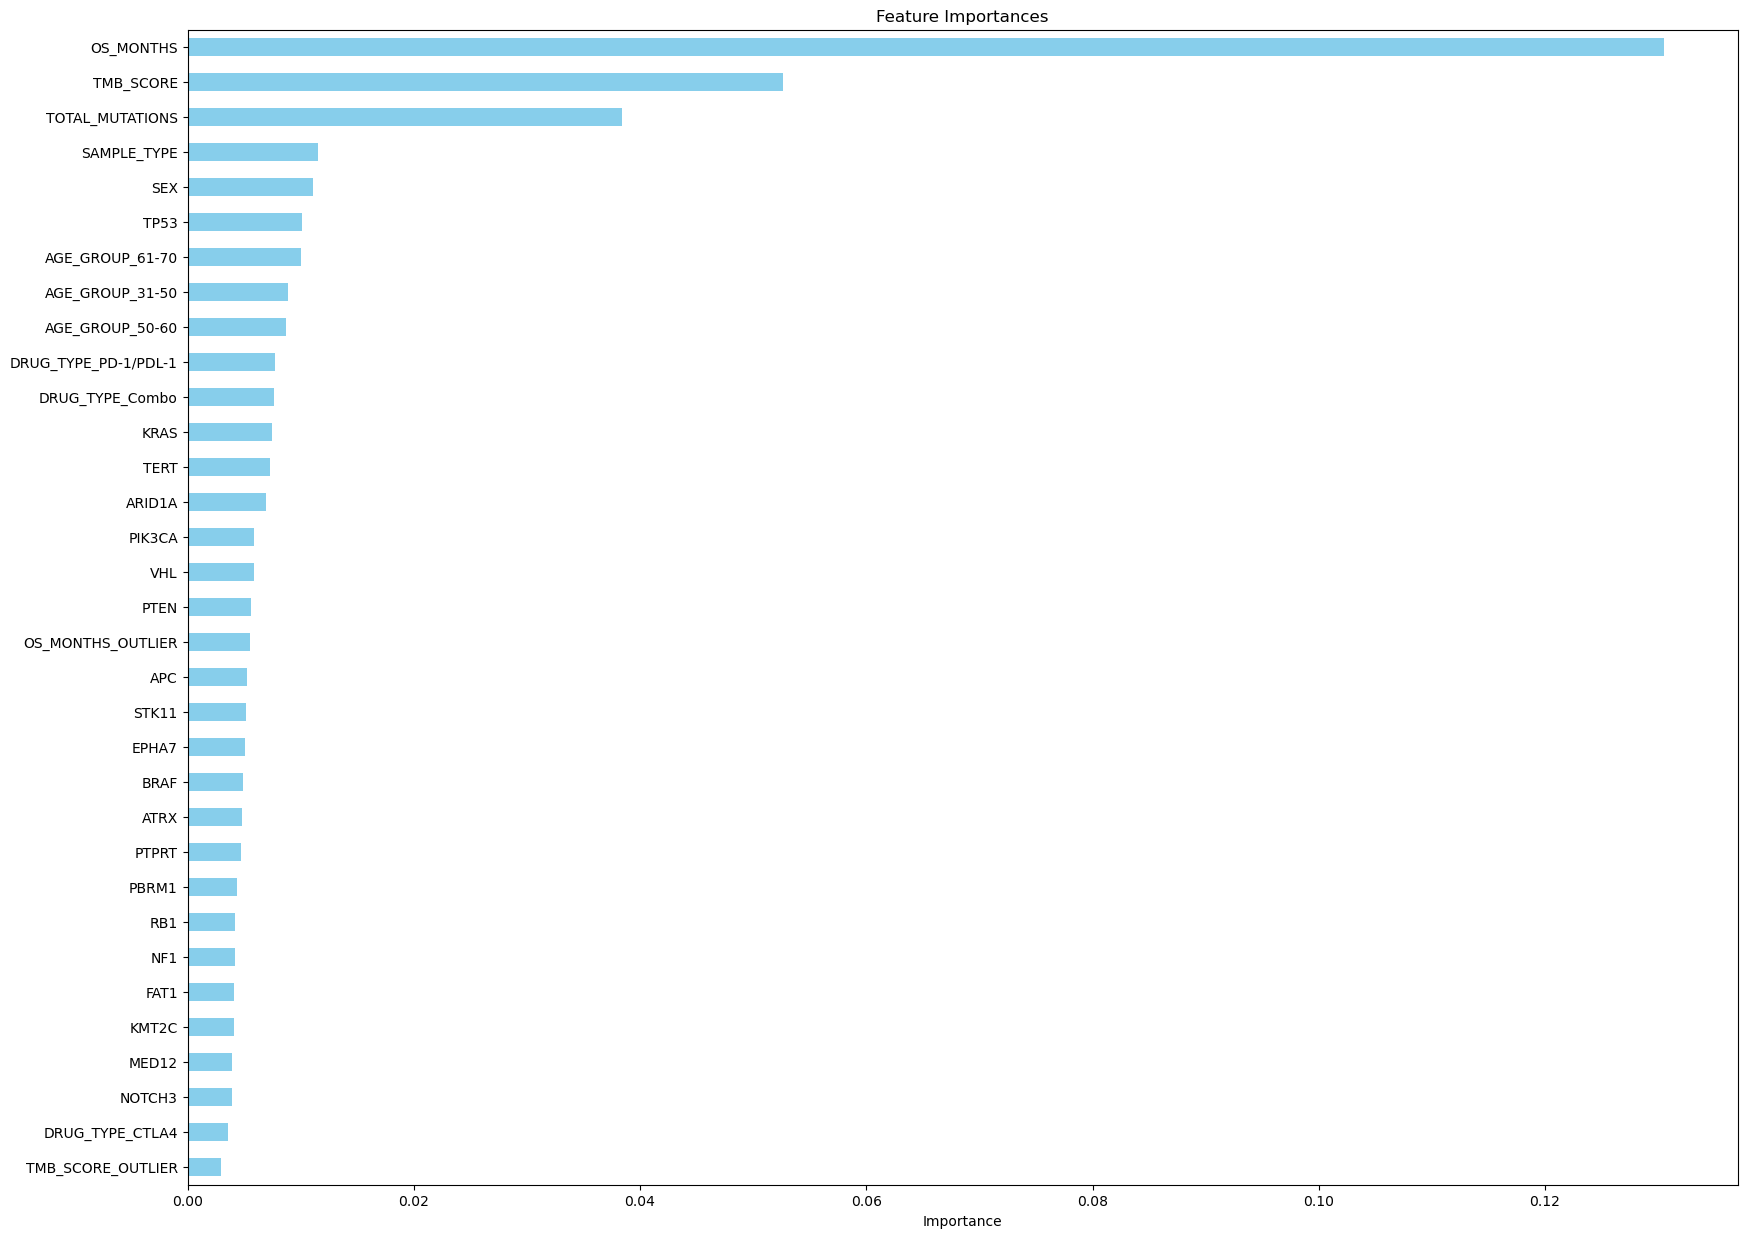

In [74]:
# Initialize the Random Forest model
model = RandomForestClassifier(random_state=42)

# Initialize a dictionary to store the feature importances
feature_importances = {}

# Split the data into features and labels
X_train = train_df.drop('OS_STATUS', axis=1)
y_train = train_df['OS_STATUS']

# Train the model
model.fit(X_train, y_train)

def evaluate(model, test_df, cancer_type):
    X_test = test_df.drop('OS_STATUS', axis=1)
    y_test = test_df['OS_STATUS']

    y_pred = model.predict(X_test)

    print(f"Model Performance for {cancer_type}:")
    print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
    print(classification_report(y_test, y_pred))
    print(confusion_matrix(y_test, y_pred))

    # Generate the confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    
    # Store the performance metrics and confusion matrix in a dictionary
    performance = {'accuracy': accuracy_score(y_test, y_pred), 'report': classification_report(y_test, y_pred), 'matrix': cm}

    importances = model.feature_importances_
    feature_importances = pd.Series(importances, index=X_train.columns)

    return feature_importances, performance

performance = {}
for cancer_type in Unique_Cancer_Type:
    feature_importances, performance[cancer_type] = evaluate(model, test_sets[cancer_type], cancer_type)

evaluate(model, skin_cancer_row_converted, 'Skin Cancer, Non-Melanoma')
    
print(f"\nFeature Importances:")
print("Top 20 Gene Mutations:")
print(feature_importances.loc['ABL1':'ZRSR2'].nlargest(20))
print("\nTMB_SCORE, SEX, OS_MONTHS, SAMPLE_TYPE, TMB_SCORE_OUTLIER, OS_MONTHS_OUTLIER, TOTAL_MUTATIONS, DRUG_TYPE:")
print(feature_importances[['TMB_SCORE', 'SEX', 'OS_MONTHS', 'SAMPLE_TYPE', 'TMB_SCORE_OUTLIER', 'OS_MONTHS_OUTLIER', 'TOTAL_MUTATIONS', 'DRUG_TYPE_CTLA4', 'DRUG_TYPE_Combo', 'DRUG_TYPE_PD-1/PDL-1']])
print("\nTop 3 AGE_GROUP:")
print(feature_importances.filter(like='AGE_GROUP').nlargest(3))

# Create a bar plot of the feature importances
top_genes = feature_importances.loc['ABL1':'ZRSR2'].nlargest(20)
other_features = feature_importances[['TMB_SCORE', 'SEX', 'OS_MONTHS', 'SAMPLE_TYPE', 'TMB_SCORE_OUTLIER', 'OS_MONTHS_OUTLIER', 'TOTAL_MUTATIONS', 'DRUG_TYPE_CTLA4', 'DRUG_TYPE_Combo', 'DRUG_TYPE_PD-1/PDL-1']]
top_age_groups = feature_importances.filter(like='AGE_GROUP').nlargest(3)
all_features = pd.concat([top_genes, other_features, top_age_groups])
colors = ['skyblue' if 'ABL1' <= feature <= 'ZRSR2' else 'skyblue' for feature in all_features.index]
all_features.sort_values().plot(kind='barh', color=colors, figsize=(20, 15))
plt.xlabel('Importance')
plt.title('Feature Importances')
plt.savefig('feature_importances.png')


### Save confusion matrix plots

In [75]:
# For each cancer type
for cancer_type in performance.keys():

    # Plot the confusion matrix
    plt.figure(figsize=(6, 6))
    cm = performance[cancer_type]['matrix']
    cmd = ConfusionMatrixDisplay(cm, display_labels=['DECEASED', 'LIVING'])
    cmd.plot(cmap='Blues')
    plt.title(f"Confusion Matrix for {cancer_type}")
    plt.savefig(f"{cancer_type.replace(' ', '_')}_Confusion_Matrix.png")
    plt.close()


<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

# Performance Metrics Analysis for Cancer Type Classification

In this section of the notebook, we analyze the performance metrics of our Random Forest Classifier for each unique cancer type, excluding 'Skin Cancer, Non-Melanoma'. The performance metrics considered are:

1. **Accuracy**: The proportion of true results among the total number of cases examined.
2. **Precision**: The proportion of true positive identifications among the total number of positive identifications.
3. **Recall (Sensitivity)**: The proportion of true positive identifications among the total number of actual positives.
4. **F1 Score**: The harmonic mean of Precision and Recall, providing a balance between the two metrics.

The steps followed in this section are:

1. **Initialize a dictionary**: We create a dictionary `performance_metrics` to store the performance metrics for each cancer type.

2. **Calculate performance metrics**: We iterate over each cancer type in the `performance` dictionary, calculate the performance metrics from the confusion matrix, and append them to the `performance_metrics` dictionary.

3. **Convert to DataFrame**: We convert the `performance_metrics` dictionary to a DataFrame `performance_df` for easier manipulation and plotting.

4. **Plot performance metrics**: We create a bar plot of the performance metrics for each cancer type, providing a visual comparison of the model's performance across different cancer types.

This analysis helps us understand how well our model performs for each cancer type, which can be useful for identifying where the model might need improvement.


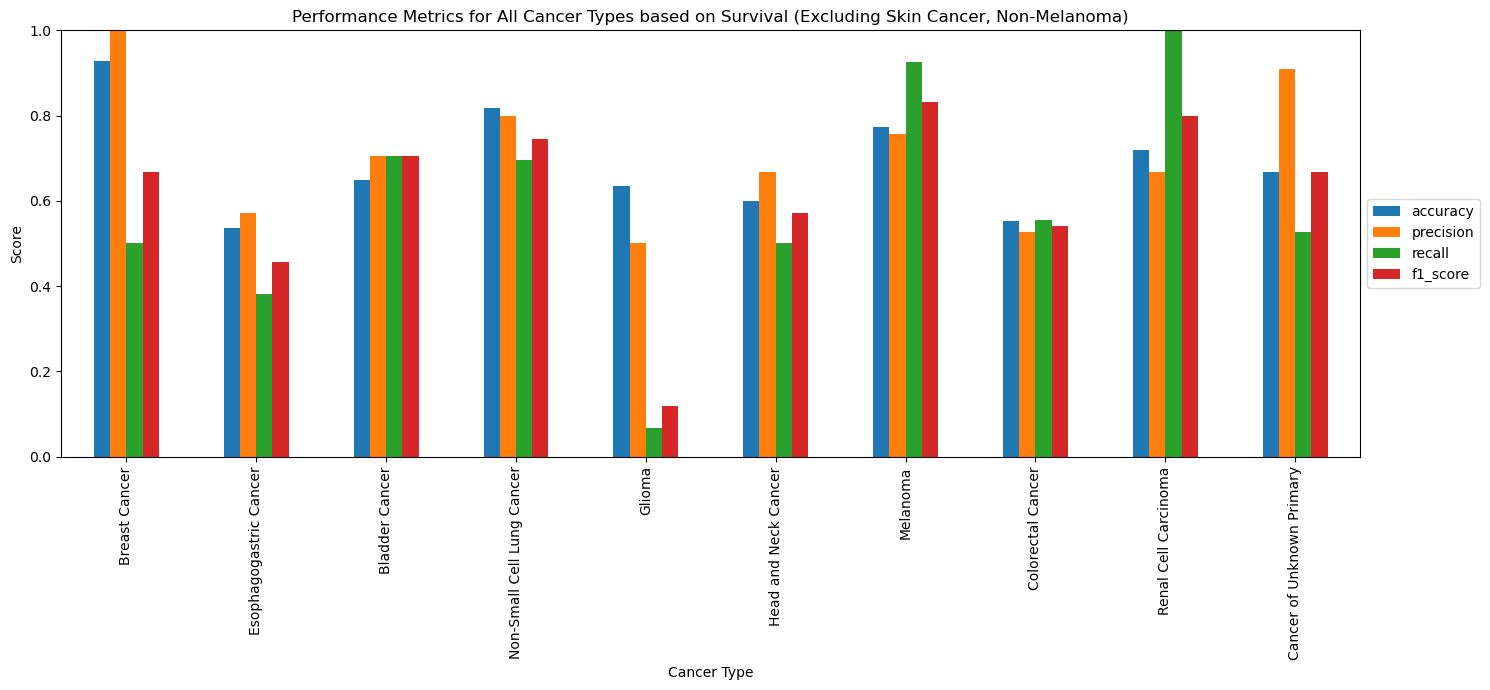

In [76]:
# Initialize a dictionary to store the performance metrics for each cancer type
performance_metrics = {'accuracy': [], 'precision': [], 'recall': [], 'f1_score': []}
cancer_types = []

# Iterate over each cancer type in the performance dictionary
for cancer_type in performance.keys():
    # Exclude 'Skin Cancer, Non-Melanoma' from the plot
    if cancer_type != 'Skin Cancer, Non-Melanoma':
        # Calculate precision, recall, and F1 score from the confusion matrix
        TN, FP, FN, TP = performance[cancer_type]['matrix'].ravel()
        precision = TP / (TP + FP)
        recall = TP / (TP + FN)
        f1_score = 2 * (precision * recall) / (precision + recall)
        
        # Append the performance metrics to the dictionary
        performance_metrics['accuracy'].append(performance[cancer_type]['accuracy'])
        performance_metrics['precision'].append(precision)
        performance_metrics['recall'].append(recall)
        performance_metrics['f1_score'].append(f1_score)
        
        # Append the cancer type to the list
        cancer_types.append(cancer_type)

# Convert the dictionary to a DataFrame
performance_df = pd.DataFrame(performance_metrics, index=cancer_types)

# Plot the performance metrics
performance_df.plot(kind='bar', figsize=(15, 7))
plt.title("Performance Metrics for All Cancer Types based on Survival (Excluding Skin Cancer, Non-Melanoma)")
plt.xlabel("Cancer Type")
plt.ylabel("Score")
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.ylim(0, 1)
plt.tight_layout()
plt.savefig("Performance_Metrics_All_Cancer_Types_Excluding_Skin_Cancer_Non_Melanoma.png")
plt.show()
plt.close()


# <font color='red'> Quick Navigation </font>
1. [Data Preprocessing](#data-preprocessing)
2. [Logistic Regression](#Logistic-Regression)
3. [Random Forest](#random-forest)
4. [Interaction](#interaction)

# <font color='blue'> Interaction between predictor genes <a name="interaction"></a></font>

<div style="background-color:lightgrey; padding:10px">

# Correlation Analysis of Gene Pairs

In this section of the notebook, we conduct a correlation analysis of gene pairs in our dataset. The aim is to identify pairs of genes that have high absolute correlation, which might suggest a relationship or interaction between these genes.

The steps followed in this section are:

1. **Filter gene columns**: We create a new dataframe `gene_df` that contains only the gene columns from the original dataframe.

2. **Compute correlation matrix**: We compute the correlation matrix of `gene_df` using the `corr` method.

3. **Identify high correlation pairs**: We identify pairs of genes that have an absolute correlation greater than 0.5. These pairs are stored in the `high_corr` dataframe.

4. **Create correlation matrix**: We create a new dataframe `high_corr_df` with the pairs of genes as indices and the correlation as the value. This dataframe is then unstacked to create a matrix `high_corr_matrix`.

5. **Plot heatmap**: We create a heatmap of `high_corr_matrix` using seaborn's `heatmap` function. This provides a visual representation of the correlations between gene pairs.

This analysis can provide insights into potential gene interactions and can be useful for further biological or medical research.


</div>


In [81]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.feature_selection import RFE
import seaborn as sns

In [79]:
# Keep only the gene columns
gene_df = df[df.columns[df.columns.get_loc('ABL1'):df.columns.get_loc('ZRSR2')+1]]

# Compute the correlation matrix
corr = gene_df.corr()

# Find pairs of genes with high absolute correlation
high_corr = corr[abs(corr) > 0.5].stack().reset_index()
high_corr = high_corr[high_corr['level_0'] < high_corr['level_1']]


In [80]:
print(high_corr)

          level_0         level_1         0
71         CDKN2A    CDKN2Ap14ARF  0.717210
72         CDKN2A  CDKN2Ap16INK4A  0.973240
75   CDKN2Ap14ARF  CDKN2Ap16INK4A  0.685260
270          MLL4           STK19  0.631272


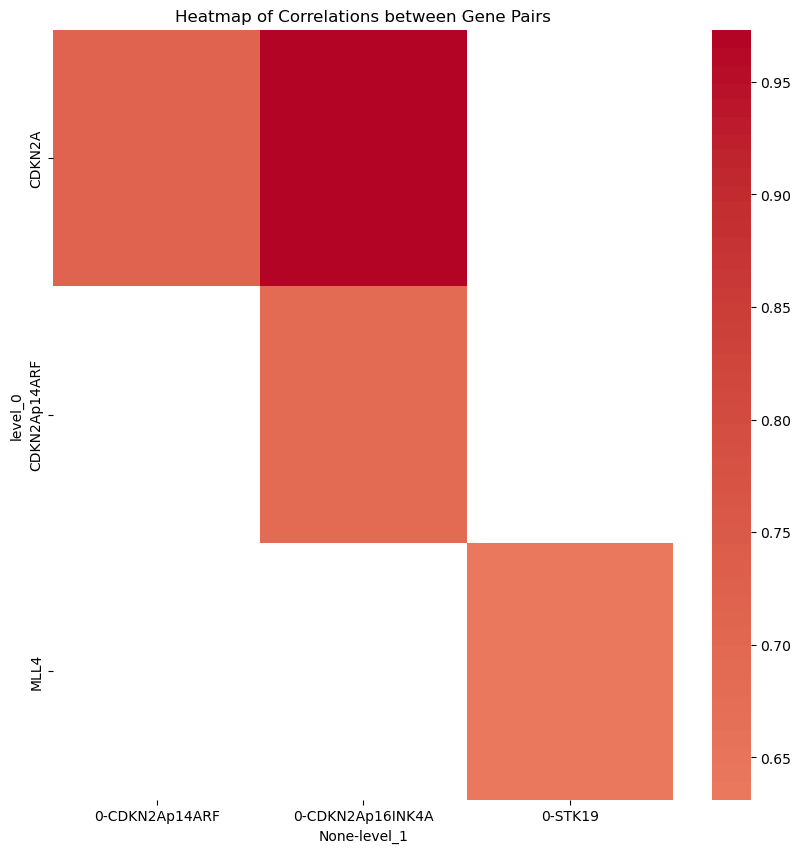

In [82]:
# Create a dataframe with the pairs of genes as indices and the correlation as the value
high_corr_df = high_corr.set_index(['level_0', 'level_1'])

# Unstack the dataframe to create a matrix
high_corr_matrix = high_corr_df.unstack()

# Plot the heatmap
plt.figure(figsize=(10,10))
sns.heatmap(high_corr_matrix, cmap='coolwarm', center=0)
plt.title('Heatmap of Correlations between Gene Pairs')
plt.show()
